# Scikit-learn for TMVA Users

*This notebook first appeared as a [blog post](//betatim.github.io/posts/sklearn-for-TMVA-users) on [Tim Head](//betatim.github.io)'s blog.*

*License: [MIT](http://opensource.org/licenses/MIT)*

*(C) 2015, Tim Head, Gilles Louppe*
*Feel free to use, distribute, and modify with the above attribution.*

Particle physics is full of machine learning. It powered the discovery of the [Higgs boson](http://en.wikipedia.org/wiki/Higgs_boson) and it is used to decide which data an experiment should record. As well as in many other analyses.

There is only one drawback: most of it is based on one library: [TMVA](https://root.cern.ch/root/html/TMVA.html). It was written many years ago, which means lots of new techniques and innovations are not available. I actually struggled to pick a good webpage to link to, as the original [homepage](//tmva.sourceforge.net/) has not been updated since 2013.

This notebook is an introduction to [scikit-learn](//scikit-learn.org/stable/) targeted at `TMVA` users. Read my earlier post explaining how to configure a [BDT in `sklearn` with the defaults from `TMVA`](/posts/matching-machine-learning/). By providing a dictionary translating from one package's lingo to the other I hope more people will give `scikit-learn` a try. This is not meant as an introduction to the various concepts, more of a reference for translating `TMVA` jargon/procedures to `scikit-learn` procedures.

**Read the second post in this series: [Advanced scikit-learn for TMVA Users](/posts/advanced-sklearn-for-TMVA/)**

It covers:

1. How to load ROOT trees
2. Plotting
  * comparing the distribution of variables in signal and background categories
  * scatter plots of two features
  * boxplots
  * correlation matrices between features
3. Training
  * the training-testing split
  * training a classifier
  * ROC curves and performance evaluation
  * plotting the classifier output for training and testing
4. How to write the classifier output to a TTree

Thanks a lot to [Gilles Louppe](//twitter.com/glouppe) for proof reading and suggestions.

As usual, first some imports:

In [1]:
%matplotlib inline

import random

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

## Loading ROOT Trees

Data comes first, the excellent [`root_numpy`](//rootpy.github.io/root_numpy/) library makes it easy to read your data stored in a ROOT TTree. Each call to `root2array` will create a 2D array which contains one row per event, and one column representing each branch you want to use.

You can download the dataset used here from [figshare](//figshare.com):

* [HIGGS-background.root](http://figshare.com/articles/HIGGS_background/1314900)
* [HIGGS-signal.root](http://figshare.com/articles/HIGGS/1314899)
 
The events are derived from the much larger [HIGGS](http://archive.ics.uci.edu/ml/datasets/HIGGS) dataset. A description of the variables can be found there as well.

In [2]:
from root_numpy import root2array, rec2array


branch_names = """lepton pT, lepton eta, lepton phi,
missing energy magnitude, missing energy phi,
jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag,
jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag,
jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag,
jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag,
m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb,
m_wwbb""".split(",")
branch_names = [c.strip() for c in branch_names]
branch_names = (b.replace(" ", "_") for b in branch_names)
branch_names = list(b.replace("-", "_") for b in branch_names)

signal = root2array("/tmp/HIGGS-signal.root",
                    "tree",
                    branch_names)
signal = rec2array(signal)

backgr = root2array("/tmp/HIGGS-background.root",
                    "tree",
                    branch_names)
backgr = rec2array(backgr)

# for sklearn data is usually organised
# into one 2D array of shape (n_samples x n_features)
# containing all the data and one array of categories
# of length n_samples
X = np.concatenate((signal, backgr))
y = np.concatenate((np.ones(signal.shape[0]),
                    np.zeros(backgr.shape[0])))

## Plotting Variables and Correlations

The `pandas` library provides high-performance, easy-to-use data structures and data analysis tools written in python. We will use it for its plotting capabilities and other nice ways to explore your data.

_Pro tip: if you want very pretty plots and more powerful plotting check out the [seaborn](//stanford.edu/~mwaskom/software/seaborn/) library. It is extremely useful._

A `DataFrame` is a 2-dimensional labeled data structure with columns of potentially different types. You can think of it like a spreadsheet or a ROOT `TTree`.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115fdf450>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x116209810>]], dtype=object)

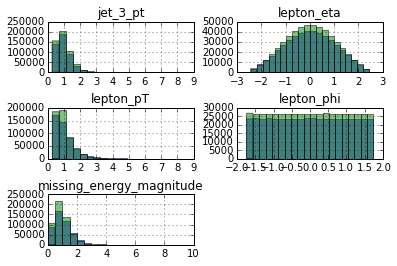

In [15]:
import pandas.core.common as com
from pandas.core.index import Index

from pandas.tools import plotting
from pandas.tools.plotting import scatter_matrix


# Create a pandas DataFrame for our data
# this provides many convenience functions
# for exploring your dataset
# need to reshape y so it is a 2D array with one column
df = pd.DataFrame(np.hstack((X, y.reshape(y.shape[0], -1))),
                  columns=branch_names+['y'])

            
def signal_background(data1, data2, column=None, grid=True,
                      xlabelsize=None, xrot=None, ylabelsize=None,
                      yrot=None, ax=None, sharex=False,
                      sharey=False, figsize=None,
                      layout=None, bins=10, **kwds):
    """Draw histogram of the DataFrame's series comparing the distribution
    in `data1` to `data2`.
    
    data1: DataFrame
    data2: DataFrame
    column: string or sequence
        If passed, will be used to limit data to a subset of columns
    grid : boolean, default True
        Whether to show axis grid lines
    xlabelsize : int, default None
        If specified changes the x-axis label size
    xrot : float, default None
        rotation of x axis labels
    ylabelsize : int, default None
        If specified changes the y-axis label size
    yrot : float, default None
        rotation of y axis labels
    ax : matplotlib axes object, default None
    sharex : bool, if True, the X axis will be shared amongst all subplots.
    sharey : bool, if True, the Y axis will be shared amongst all subplots.
    figsize : tuple
        The size of the figure to create in inches by default
    layout: (optional) a tuple (rows, columns) for the layout of the histograms
    bins: integer, default 10
        Number of histogram bins to be used
    kwds : other plotting keyword arguments
        To be passed to hist function
    """
        
    if 'alpha' not in kwds:
        kwds['alpha'] = 0.5

    if column is not None:
        if not isinstance(column, (list, np.ndarray, Index)):
            column = [column]
        data1 = data1[column]
        data2 = data2[column]
        
    data1 = data1._get_numeric_data()
    data2 = data2._get_numeric_data()
    naxes = len(data1.columns)

    fig, axes = plotting._subplots(naxes=naxes, ax=ax, squeeze=False,
                                   sharex=sharex,
                                   sharey=sharey,
                                   figsize=figsize,
                                   layout=layout)
    _axes = plotting._flatten(axes)

    for i, col in enumerate(com._try_sort(data1.columns)):
        ax = _axes[i]
        low = min(data1[col].min(), data2[col].min())
        high = max(data1[col].max(), data2[col].max())
        ax.hist(data1[col].dropna().values,
                bins=bins, range=(low,high), **kwds)
        ax.hist(data2[col].dropna().values,
                bins=bins, range=(low,high), **kwds)
        ax.set_title(col)
        ax.grid(grid)

    plotting._set_ticks_props(axes, xlabelsize=xlabelsize, xrot=xrot,
                              ylabelsize=ylabelsize, yrot=yrot)
    fig.subplots_adjust(wspace=0.3, hspace=0.7)

    return axes

# Plot signal and background distributions for some
# variables
# The first two arguments select what is "signal"
# and what is "background". This means you can
# use it for more general comparisons of two
# subsets as well.
signal_background(df[df.y<0.5], df[df.y>0.5],
                  column=["lepton_pT",
                          "lepton_eta",
                          "lepton_phi",
                          "missing_energy_magnitude",
                          "jet_3_pt"],
                  bins=20)

## Scatter Plots

Can we see anything by plotting one of the features against another? If you want to make a scatter plot of two features use [`df.plot(kind='scatter')`](//pandas.pydata.org/pandas-docs/stable/visualization.html#scatter-plot). Here we pick 1000 data points at random, with 1million points the plot would be far too dense to see anything.

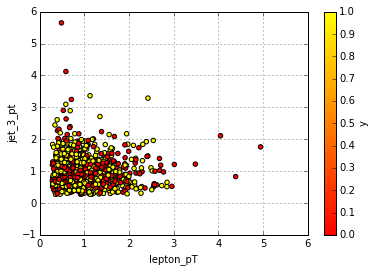

In [4]:
df.ix[random.sample(df.index, 1000)].plot(kind='scatter',
                                          x='lepton_pT', y='jet_3_pt',
                                          c='y', cmap='autumn')

In the plot above compares the distribution of the feature `lepton_pT` vs `jet_3_pt`. The colour of each point shows which class it belongs to: 0 for background and +1 for signal. Not the most useful plot in this case, but it is here for reference.

## Boxplots

A [Box plot](//en.wikipedia.org/wiki/Box_plot) is a nice way of visualising a distribution by showing it's quantiles. Below we make box plots for the features `lepton_pT`, `lepton_eta`, `missing_energy_magnitude` and `jet_3_pt` using [`df.boxplot()`](//pandas.pydata.org/pandas-docs/stable/visualization.html#box-plots). Each plot shows the distribution of one feature for signal and background. You can also group the distributions by the number of jets in an event, or the value of any other feature in your dataset.

OrderedDict([('lepton_pT', <matplotlib.axes._subplots.AxesSubplot object at 0x10ca08410>), ('lepton_eta', <matplotlib.axes._subplots.AxesSubplot object at 0x153711cd0>), ('missing_energy_magnitude', <matplotlib.axes._subplots.AxesSubplot object at 0x153796550>), ('jet_3_pt', <matplotlib.axes._subplots.AxesSubplot object at 0x1537f9d10>)])

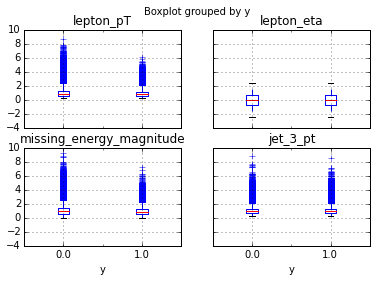

In [5]:
df.boxplot(by='y',
           column=["lepton_pT",
                   "lepton_eta",
                   "missing_energy_magnitude",
                   "jet_3_pt"],
           return_type='axes')

## Correlation Matrix

The correlation between features can be plotted with [`df.corr()`](//pandas.pydata.org/pandas-docs/stable/computation.html#correlation). For this data set the plots are not the most exciting as the variables are not correlated with each other.

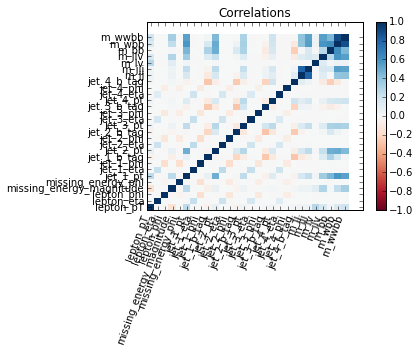

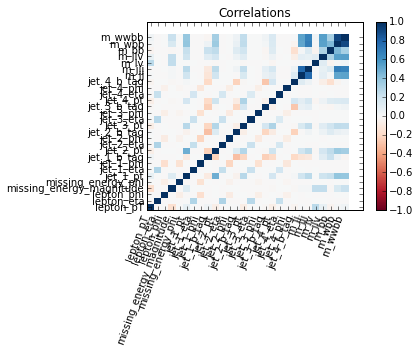

In [6]:
bg = df.y < 0.5
sig = df.y > 0.5

def correlations(data, **kwds):
    """Calculate pairwise correlation between features.
    
    Extra arguments are passed on to DataFrame.corr()
    """
    # simply call df.corr() to get a table of
    # correlation values if you do not need
    # the fancy plotting
    corrmat = data.corr(**kwds)

    fig, ax1 = plt.subplots(ncols=1, figsize=(6,5))
    
    opts = {'cmap': plt.get_cmap("RdBu"),
            'vmin': -1, 'vmax': +1}
    heatmap1 = ax1.pcolor(corrmat, **opts)
    plt.colorbar(heatmap1, ax=ax1)

    ax1.set_title("Correlations")

    labels = corrmat.columns.values
    for ax in (ax1,):
        # shift location of ticks to center of the bins
        ax.set_xticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_yticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_xticklabels(labels, minor=False, ha='right', rotation=70)
        ax.set_yticklabels(labels, minor=False)
        
    plt.tight_layout()
    
# remove the y column from the correlation matrix
# after using it to select background and signal
correlations(df[bg].drop('y', 1))
correlations(df[sig].drop('y', 1))

## The Training and Testing Split

One of the first things to do is split your data into a training and testing set. This will split your data into train-test sets: 67%-33%. It will also shuffle entries so you will not get the first 67% of `X` for training and the last 33% for testing. This is particularly important in cases where you load all signal events first and then the background events.

Here we split our data into two independent samples twice. The first split is to create a development and a evaluation set. All development and performance evaluation will be done with the development set. Once the hyper-parameters and other settings are frozen we can use the evaluation set to get an unbiased estimate of the performance.

The development set is further split into a training and testing set. The first will be used for training the classifier and the second to evaluate its performance.

In [7]:
from sklearn.cross_validation import train_test_split

X_dev,X_eval, y_dev,y_eval = train_test_split(X, y,
                                              test_size=0.33, random_state=42)
X_train,X_test, y_train,y_test = train_test_split(X_dev, y_dev,
                                                  test_size=0.33, random_state=492)

## Training Decision Trees

Training a [AdaBoost Decision Tree](//en.wikipedia.org/wiki/AdaBoost) in `sklearn` is straight forward. Import the type of decision tree you want and off you go. Here we set several hyper-parameters to non default values in order to make the classifier as similar to the default BDT in `TMVA` as possible. See my [Matching Machine Learning](/posts/matching-machine-learning/) post for more details on finding these settings.

After instantiating our [`AdaBoostClassifier`](//scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html), call the `fit()` method with the training sample as an argument. This will train the tree, now we are ready to evaluate the performance on the held out testing set.

_Pro tip: In TMVA many different ensemble methods that use decision trees as their base estimator are mixed together under the name BDT. Remember this when you discuss things with your local machine learning guru as they will want to know what you are doing in much more detail._

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

dt = DecisionTreeClassifier(max_depth=3,
                            min_samples_leaf=0.05*len(X_train))
bdt = AdaBoostClassifier(dt,
                         algorithm='SAMME',
                         n_estimators=800,
                         learning_rate=0.5)

bdt.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(compute_importances=None, criterion='gini',
            max_depth=3, max_features=None, max_leaf_nodes=None,
            min_density=None, min_samples_leaf=22445.0,
            min_samples_split=2, random_state=None, splitter='best'),
          learning_rate=0.5, n_estimators=800, random_state=None)

The `fit()` method returns the trained classifier. When printed out all the hyper-parameters are listed.

## Assessing a Classifier's Performance

Next let's create a quick report on how well our classifier is doing. It is important to make sure you use samples not seen by the classifier to get an unbiased estimate of its performance. 

In [10]:
y_predicted = bdt.predict(X_test)
print classification_report(y_test, y_predicted,
                            target_names=["background", "signal"])
print "Area under ROC curve: %.4f"%(roc_auc_score(y_test,
                                                  bdt.decision_function(X_test)))

             precision    recall  f1-score   support

 background       0.72      0.71      0.71    104165
     signal       0.74      0.75      0.75    116935

avg / total       0.73      0.73      0.73    221100

Area under ROC curve: 0.8082


To illustrate that point, here the same performance metrics evaluated on the training set instead. You can see the estimates of the performance are more optimistic than on an unseen set of events.

In [18]:
y_predicted = bdt.predict(X_train)
print classification_report(y_train, y_predicted,
                            target_names=["background", "signal"])
print "Area under ROC curve: %.4f"%(roc_auc_score(y_train,
                                                  bdt.decision_function(X_train)))

             precision    recall  f1-score   support

 background       0.72      0.71      0.72    210793
     signal       0.75      0.76      0.75    238107

avg / total       0.74      0.74      0.74    448900

Area under ROC curve: 0.8161


Another useful plot to judge the performance of a classifier is to look at the ROC curve directly.

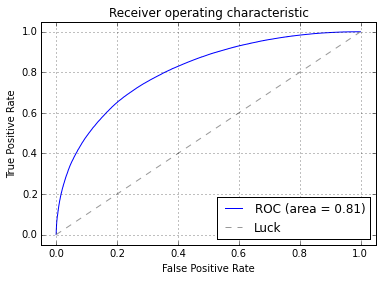

In [17]:
from sklearn.metrics import roc_curve, auc

decisions = bdt.decision_function(X_test)
# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_test, decisions)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Overtraining Check

Comparing the BDT's output distribution for the training and testing set is a popular way in HEP to check for overtraining. The `compare_test_train()` method will plot the BDT's decision function for each class, as well as overlaying it with the shape of the decision function in the training set.

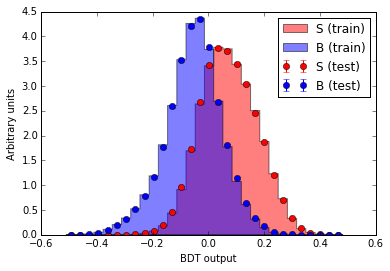

In [12]:
def compare_train_test(clf, X_train, y_train, X_test, y_test, bins=30):
    decisions = []
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    
    plt.hist(decisions[0],
             color='r', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', normed=True,
             label='S (train)')
    plt.hist(decisions[1],
             color='b', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', normed=True,
             label='B (train)')

    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')
    
    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')

    plt.xlabel("BDT output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')
    
compare_train_test(bdt, X_train, y_train, X_test, y_test)

## Writing the Classifier Output to a TTree

The final step is writing the classifier's output for each event into a `TTree` for further processing later on. The `numpy_root` library can read and write TTrees. We could write out each branch used as a feature as well as the classifier output or simply write out the classifier and then "friend" the resulting `TTree` with the original one. Doing the latter is a little less typing here so we do that. If you want to recreate the whole tree with each feature, you have to setup the data types and branch names correctly, but otherwise it is the same.

In [239]:
from root_numpy import array2root

y_predicted = bdt.decision_function(X)
y_predicted.dtype = [('y', np.float64)]

array2root(y_predicted, "/tmp/test-prediction.root", "BDToutput")

## The End

Thank you for reading. You can refer to this post for recipes how to do the most common things from TMVA with scikit-learn. There will be a second post with more advanced techniques which are not available in TMVA, but very common in the machine learning world.

The second post is now public: [Advanced scikit-learn for TMVA Users](/posts/advanced-sklearn-for-TMVA/).

If you find a mistake or want to tell me something else [catch me on twitter](//twitter.com/betatim).